In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.cm as cm
import helper

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

In [3]:
df = pd.read_csv('Ames_Housing_Price_Data.csv', 
                             index_col=0,low_memory = False)

In [4]:
train, test = helper.data_processing_wrapper(df, num_to_cat_list=[], remove_PID=False)

In [5]:
train['LogSalePrice'] = np.log(train['SalePrice'])
test['LogSalePrice'] = np.log(test['SalePrice'])

In [6]:
categorical = train.select_dtypes(['object','bool']).columns.to_list() + ['MSSubClass']

In [7]:
X_train = train.drop(['SalePrice', 'LogSalePrice', 'PID', 'TotalBsmtSF', 'GrLivArea'], axis=1)
y_train = train['LogSalePrice']
X_test = test.drop(['SalePrice', 'LogSalePrice', 'PID', 'TotalBsmtSF', 'GrLivArea'], axis=1)
y_test = test['LogSalePrice']

### Note we are keeping various features related to the sale. The justification of some is clearer than others.

## We first build a single basic model to be trained on all of X_train. 

## (all) Lasso for selection.

In [8]:
def Lasso_select(X, y, alpha):

    pipe = Pipeline(
        [
            ('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown = 'ignore'), categorical)], 
                                                remainder='passthrough')),
            ('scaler', StandardScaler(with_mean=False))
        ]
    )
    
    X = pipe.fit_transform(X)

    cv = KFold(n_splits=4, shuffle=True, random_state=42)

    cross = cross_val_score(Lasso(alpha=alpha, max_iter=5000), X, y, scoring='r2', cv=cv, n_jobs=-1)
    
    selector = SelectFromModel(Lasso(alpha=alpha, max_iter=5000))
    selector.fit(X,y)
    num_features = np.sum(selector.get_support())
    
    return cross, num_features

In [9]:
for alpha in np.logspace(-5, -1, 5):
    print(Lasso_select(X_train, y_train, alpha))

(array([0.93200346, 0.92152371, 0.9353926 , 0.94437605]), 231)
(array([0.93389146, 0.92929265, 0.93716305, 0.94446891]), 224)
(array([0.93987731, 0.93567321, 0.94397679, 0.94652093]), 161)
(array([0.91720404, 0.91750558, 0.93221943, 0.93146827]), 48)
(array([0.67913054, 0.6968    , 0.70571303, 0.70438037]), 6)


In [10]:
for alpha in [0.006, 0.0062, 0.0064, 0.0066, 0.0068]:
    print(Lasso_select(X_train,y_train,alpha))

(array([0.93012945, 0.92795729, 0.94045178, 0.94021857]), 63)
(array([0.92960553, 0.92745122, 0.94014199, 0.93982576]), 59)
(array([0.92906261, 0.92692403, 0.93983048, 0.93943728]), 59)
(array([0.92849244, 0.92638286, 0.93950739, 0.93902865]), 57)
(array([0.92789179, 0.92582893, 0.93918776, 0.93863655]), 55)


## (all) We will try to keep the number of features below 60 so let's move ahead with Lasso_alpha = 0.0064.

### What are those features?

In [11]:
pipe = Pipeline(
        [
            ('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown = 'ignore'), categorical)], 
                                                remainder='passthrough')),
            ('scaler', StandardScaler(with_mean=False))
        ]
    )
    
X = pipe.fit_transform(X_train)
y = y_train

selector = SelectFromModel(Lasso(alpha=0.01, max_iter=5000))
selector.fit(X,y)
mask = selector.get_support()
feat_names = pipe.named_steps['transformer'].get_feature_names()
names = [name for name, boo in zip(feat_names, mask) if boo]
names

['Cat__x0_C (all)',
 'Cat__x0_RM',
 'Cat__x2_Reg',
 'Cat__x7_ClearCr',
 'Cat__x7_Crawfor',
 'Cat__x7_Edwards',
 'Cat__x7_GrnHill',
 'Cat__x7_MeadowV',
 'Cat__x7_NoRidge',
 'Cat__x7_Somerst',
 'Cat__x7_StoneBr',
 'Cat__x8_Norm',
 'Cat__x10_1Fam',
 'Cat__x10_Twnhs',
 'Cat__x14_BrkFace',
 'Cat__x14_PreCast',
 'Cat__x17_PConc',
 'Cat__x21_N',
 'Cat__x23_Typ',
 'Cat__x28_Normal',
 'Cat__x29_30',
 'Cat__x29_60',
 'Cat__x29_160',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'HalfBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'ScreenPorch']

## (all) Train a Ridge regression on the selected features.

In [12]:
X = X_train
y = y_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.0064, max_iter=10000))),
                 ('ridge', Ridge())])


param_grid = {'ridge__alpha':[0.001, 0.1, 1, 10]}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'ridge__alpha': 0.001}
0.9397875270278928


In [13]:
X = X_train
y = y_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.0064, max_iter=10000))),
                 ('ridge', Ridge())])


param_grid = {'ridge__alpha':[0.000001, 0.00001, 0.0001, 0.001]}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'ridge__alpha': 1e-05}
0.9397875413675051


## The model does not find a Ridge penalty useful. We will try Lasso instead.

In [14]:
X = X_train
y = y_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.0064, max_iter=10000))),
                 ('lasso', Lasso())])


param_grid = {'lasso__alpha':[0.001, 0.1, 1, 10]}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'lasso__alpha': 0.001}
0.939989925289379


In [15]:
X = X_train
y = y_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.0064, max_iter=10000))),
                 ('lasso', Lasso())])


param_grid = {'lasso__alpha':[0.000001, 0.00001, 0.0001, 0.001]}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'lasso__alpha': 0.001}
0.939989925289379


In [16]:
X = X_train
y = y_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.0064, max_iter=10000))),
                 ('lasso', Lasso())])


param_grid = {'lasso__alpha':np.linspace(0.0001, 0.01, 1000)}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'lasso__alpha': 0.0011603603603603605}
0.9399949518702337


## The gridsearch has selected a Lasso penalty with alpha=0.0012.

### We now evaluate the chosen model on the test data.

In [17]:
pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.0064, max_iter=10000))),
                 ('lasso', Lasso(alpha=0.0012))])

pipe.fit(X_train, y_train)

print(f'The train score is {pipe.score(X_train, y_train)}')
print(f'The test score is {pipe.score(X_test, y_test)}')

The train score is 0.9479308958186432
The test score is 0.9130720572280785


## This represents a sensible baseline. A Lasso model with 58 features (after one-hot encoding) and no engineering has a test score of 91.3%

# Now begins the separation of the data into two clusters, with a model trained on each.

In [18]:
nhds = train.groupby('Neighborhood').median()[['LogSalePrice', 'GrLivArea']]

In [19]:
weights = train.groupby('Neighborhood').count().apply(lambda x: x['PID']/len(train) ,axis=1).to_list()

In [20]:
scaler = StandardScaler()
_ = scaler.fit_transform(nhds)
clusterer = KMeans(n_clusters=2, random_state=42)
cluster_labels = clusterer.fit_predict(_, sample_weight=weights)
nhds['Cluster'] = cluster_labels

In [21]:
cluster_dict = nhds['Cluster'].to_dict()

In [22]:
train['NhdCluster'] = train.apply(lambda x: cluster_dict[x['Neighborhood']], axis=1)
test['NhdCluster'] = test.apply(lambda x: cluster_dict[x['Neighborhood']], axis=1)

### Let's have a look at the distribution of LogSalePrice within the two clusters.

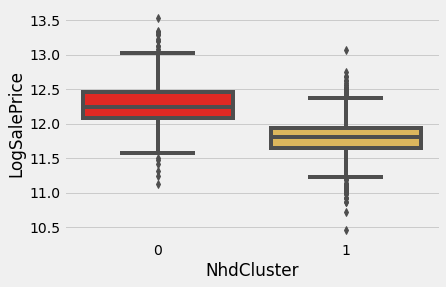

In [23]:
sns.boxplot(x='NhdCluster', y='LogSalePrice', data=train)
plt.show()

### A closer look at the numbers suggests excluding from each cluster any house whose LogSalePrice is more than 3.5 standard deviations from the respective mean.

In [24]:
zscore_0 = stats.zscore(train.loc[train['NhdCluster']==0,:]['LogSalePrice'])
zscore_1 = stats.zscore(train.loc[train['NhdCluster']==1,:]['LogSalePrice'])

In [25]:
X0_train = train.loc[train['NhdCluster']==0,:]
X0_train = X0_train.assign(z_score=zscore_0)
X0_train = X0_train.loc[abs(X0_train['z_score'])<=3.5,:]

y0_train = X0_train['LogSalePrice']

X0_train = X0_train.drop(['SalePrice', 'LogSalePrice', 'PID', 'TotalBsmtSF', 'GrLivArea', 'NhdCluster', 'z_score'], axis=1)

X1_train = train.loc[train['NhdCluster']==1,:]
X1_train = X1_train.assign(z_score=zscore_1)
X1_train = X1_train.loc[abs(X1_train['z_score'])<=3.5,:]

y1_train = X1_train['LogSalePrice']

X1_train = X1_train.drop(['SalePrice', 'LogSalePrice', 'PID', 'TotalBsmtSF', 'GrLivArea', 'NhdCluster', 'z_score'], axis=1)

In [26]:
X0_test = test.loc[test['NhdCluster']==0,:].drop(['SalePrice', 'LogSalePrice', 'PID', 'TotalBsmtSF', 'GrLivArea', 'NhdCluster'], axis=1)
y0_test = test.loc[test['NhdCluster']==0, 'LogSalePrice']

X1_test = test.loc[test['NhdCluster']==1,:].drop(['SalePrice', 'LogSalePrice', 'PID', 'TotalBsmtSF', 'GrLivArea', 'NhdCluster'], axis=1)
y1_test = test.loc[test['NhdCluster']==1, 'LogSalePrice']

In [27]:
print(X0_train.shape)
print(X1_train.shape)
print('\n')
print(y0_train.shape)
print(y1_train.shape)
print('\n')
print(X0_test.shape)
print(X1_test.shape)
print('\n')
print(y0_test.shape)
print(y1_test.shape)

(894, 77)
(972, 77)


(894,)
(972,)


(298, 77)
(326, 77)


(298,)
(326,)


In [28]:
print(np.std(y0_train)/np.mean(y0_train))
print(np.std(y0_test)/np.mean(y0_test))
print(np.std(y1_train)/np.mean(y1_train))
print(np.std(y1_test)/np.mean(y1_test))

0.024816663696616077
0.024099613361273996
0.022833937838102777
0.02285355595124185


## (cluster 0) Lasso for selection.

In [29]:
def Lasso_select(X, y, alpha):

    pipe = Pipeline(
        [
            ('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown = 'ignore'), categorical)], 
                                                remainder='passthrough')),
            ('scaler', StandardScaler(with_mean=False))
        ]
    )
    
    X = pipe.fit_transform(X)

    cv = KFold(n_splits=4, shuffle=True, random_state=42)

    cross = cross_val_score(Lasso(alpha=alpha, max_iter=10000), X, y, scoring='r2', cv=cv, n_jobs=-1)
    
    selector = SelectFromModel(Lasso(alpha=alpha, max_iter=10000))
    selector.fit(X,y)
    num_features = np.sum(selector.get_support())
    
    return cross, num_features

In [30]:
for alpha in np.logspace(-5, -1, 5):
    print(Lasso_select(X0_train,y0_train,alpha))

(array([0.88824536, 0.85572917, 0.90619718, 0.87962978]), 192)
(array([0.90080098, 0.87769385, 0.9113688 , 0.88187899]), 186)
(array([0.91809411, 0.91466066, 0.93430162, 0.90902892]), 129)
(array([0.90331543, 0.90907951, 0.91167745, 0.8802307 ]), 42)
(array([0.59182243, 0.58649533, 0.60354391, 0.54646262]), 4)


In [31]:
for alpha in np.linspace(0.001, 0.01, 10):
    print(Lasso_select(X0_train,y0_train,alpha))

(array([0.91809411, 0.91466066, 0.93430162, 0.90902892]), 129)
(array([0.91990373, 0.9196472 , 0.9348835 , 0.90392731]), 106)
(array([0.92000552, 0.92051019, 0.93518145, 0.90012572]), 89)
(array([0.91957216, 0.92038801, 0.93352767, 0.89733749]), 75)
(array([0.91960278, 0.91946563, 0.93096727, 0.89565254]), 65)
(array([0.91745431, 0.91808749, 0.92778617, 0.89357409]), 57)
(array([0.91401244, 0.91632543, 0.92371852, 0.89080406]), 50)
(array([0.91065519, 0.91439731, 0.91946263, 0.8876101 ]), 48)
(array([0.9071463 , 0.91203613, 0.91548451, 0.88415468]), 45)
(array([0.90331543, 0.90907951, 0.91167745, 0.8802307 ]), 42)


In [32]:
Lasso_select(X0_train,y0_train,0.006)

(array([0.91745431, 0.91808749, 0.92778617, 0.89357409]), 57)

## (cluster 1) Lasso for selection.

In [33]:
for alpha in np.logspace(-5, -1, 5):
    print(Lasso_select(X1_train,y1_train,alpha))

(array([0.80838551, 0.87401652, 0.82495011, 0.82732024]), 206)
(array([0.82423342, 0.87966978, 0.82877865, 0.83065792]), 201)
(array([0.84679986, 0.89198716, 0.84626664, 0.84123723]), 151)
(array([0.81895534, 0.85778359, 0.83419834, 0.81854292]), 43)
(array([0.36738818, 0.39726793, 0.36945174, 0.39008811]), 3)


In [34]:
for alpha in np.linspace(0.001, 0.01, 10):
    print(Lasso_select(X1_train,y1_train,alpha))

(array([0.84679986, 0.89198716, 0.84626664, 0.84123723]), 151)
(array([0.84791092, 0.89224794, 0.84822655, 0.8416111 ]), 119)
(array([0.84381834, 0.88994646, 0.85025085, 0.83958597]), 102)
(array([0.84011511, 0.88618193, 0.85013339, 0.83598142]), 84)
(array([0.83671949, 0.88184594, 0.84795852, 0.83304243]), 70)
(array([0.83460578, 0.87682922, 0.84525355, 0.8299465 ]), 63)
(array([0.83156307, 0.87256555, 0.84237113, 0.82729626]), 53)
(array([0.82803508, 0.8675696 , 0.84002148, 0.82482095]), 49)
(array([0.82386493, 0.86256528, 0.83732922, 0.82180093]), 46)
(array([0.81895534, 0.85778359, 0.83419834, 0.81854292]), 43)


In [35]:
Lasso_select(X1_train,y1_train,0.006)

(array([0.83460578, 0.87682922, 0.84525355, 0.8299465 ]), 63)

## Will try working with (come back to this) (one-hot encoded) features respectively.

## (cluster 0) Ridge for robustness.

In [36]:
X = X0_train
y = y0_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean = False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.006, max_iter=10000))),
                 ('ridge', Ridge())])


param_grid = {'ridge__alpha':[0.001, 0.1, 1, 10]}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'ridge__alpha': 1}
0.9089672155124486


In [37]:
X = X0_train
y = y0_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.006, max_iter=10000))),
                 ('ridge', Ridge())])

param_grid = {'ridge__alpha':np.linspace(0.1, 10, 1000)}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'ridge__alpha': 1.546846846846847}
0.9089687899098668


## (cluster 1) Ridge for robustness.

In [38]:
X = X1_train
y = y1_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean = False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.006, max_iter=10000))),
                 ('ridge', Ridge())])


param_grid = {'ridge__alpha':[0.001, 0.1, 1, 10]}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'ridge__alpha': 10}
0.8464427463560691


In [39]:
X = X1_train
y = y1_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.006, max_iter=10000))),
                 ('ridge', Ridge())])

param_grid = {'ridge__alpha':np.linspace(1, 20, 1000)}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'ridge__alpha': 14.066066066066067}
0.8464665737700479


## Trying Lasso on Cluster 1

In [40]:
X = X1_train
y = y1_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.007, max_iter=10000))),
                 ('lasso', Lasso())])


param_grid = {'lasso__alpha':[0.001, 0.1, 1, 10]}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'lasso__alpha': 0.001}
0.8484104199029453


In [41]:
X = X1_train
y = y1_train

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.007, max_iter=10000))),
                 ('lasso', Lasso())])

param_grid = {'lasso__alpha':np.linspace(0.0001, 0.1, 1000)}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'lasso__alpha': 0.0029}
0.8498413894565529


## Now putting it all together.

In [42]:
pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.006, max_iter=10000))),
                 ('ridge', Ridge(alpha=1.55))])

pipe.fit(X0_train, y0_train)

cluster0_train_predict = pipe.predict(X0_train)
cluster0_test_predict = pipe.predict(X0_test)

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('selector', SelectFromModel(Lasso(alpha=0.006, max_iter=10000))),
                 ('ridge', Ridge(alpha=14.07))])

pipe.fit(X1_train, y1_train)

cluster1_train_predict = pipe.predict(X1_train)
cluster1_test_predict = pipe.predict(X1_test)

In [43]:
cluster0_train_predict = pd.DataFrame(cluster0_train_predict).rename(columns={0:'prediction'})
cluster1_train_predict = pd.DataFrame(cluster1_train_predict).rename(columns={0:'prediction'})
cluster0_test_predict = pd.DataFrame(cluster0_test_predict).rename(columns={0:'prediction'})
cluster1_test_predict = pd.DataFrame(cluster1_test_predict).rename(columns={0:'prediction'})

train_predict = pd.concat([cluster0_train_predict, cluster1_train_predict])
test_predict = pd.concat([cluster0_test_predict, cluster1_test_predict])
train_target = pd.concat([y0_train, y1_train])
test_target = pd.concat([y0_test, y1_test])

In [44]:
print(len(train_predict))
print(len(test_predict))
print(len(train_target))
print(len(test_target))

1866
624
1866
624


In [45]:
print(f'Train score is {r2_score(train_target, train_predict)}')
print(f'Test score is {r2_score(test_target, test_predict)}')

Train score is 0.9539644940789149
Test score is 0.9112798644837746


In [46]:
print(f'Cluster 0 train score is {r2_score(y0_train, cluster0_train_predict)}')
print(f'Cluster 0 test score is {r2_score(y0_test, cluster0_test_predict)}')
print('\n')
print(f'Cluster 1 train score is {r2_score(y1_train, cluster1_train_predict)}')
print(f'Cluster 1 test score is {r2_score(y1_test, cluster1_test_predict)}')

Cluster 0 train score is 0.9430191481514386
Cluster 0 test score is 0.9244314433112969


Cluster 1 train score is 0.8944097861900325
Cluster 1 test score is 0.7500361592919025


## Previous best parameters for comparison.

In [47]:
pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler()),
                 ('selector', SelectFromModel(Lasso(alpha=0.006, max_iter=10000))),
                 ('ridge', Ridge(alpha=1.33))])

pipe.fit(X0_train, y0_train)

cluster0_train_predict = pipe.predict(X0_train)
cluster0_test_predict = pipe.predict(X0_test)

pipe = Pipeline([('transformer', ColumnTransformer([("Cat", OneHotEncoder(handle_unknown='ignore'), categorical)], 
                                            remainder='passthrough')),
                 ('scaler', StandardScaler()),
                 ('selector', SelectFromModel(Lasso(alpha=0.008, max_iter=10000))),
                 ('lasso', Lasso(alpha=0.002))])

pipe.fit(X1_train, y1_train)

cluster1_train_predict = pipe.predict(X1_train)
cluster1_test_predict = pipe.predict(X1_test)

In [48]:
cluster0_train_predict = pd.DataFrame(cluster0_train_predict).rename(columns={0:'prediction'})
cluster1_train_predict = pd.DataFrame(cluster1_train_predict).rename(columns={0:'prediction'})
cluster0_test_predict = pd.DataFrame(cluster0_test_predict).rename(columns={0:'prediction'})
cluster1_test_predict = pd.DataFrame(cluster1_test_predict).rename(columns={0:'prediction'})

train_predict = pd.concat([cluster0_train_predict, cluster1_train_predict])
test_predict = pd.concat([cluster0_test_predict, cluster1_test_predict])
train_target = pd.concat([y0_train, y1_train])
test_target = pd.concat([y0_test, y1_test])

In [49]:
print(len(train_predict))
print(len(test_predict))
print(len(train_target))
print(len(test_target))

1866
624
1866
624


In [50]:
print(f'Train score is {r2_score(train_target, train_predict)}')
print(f'Test score is {r2_score(test_target, test_predict)}')

Train score is 0.9504968659821477
Test score is 0.912620746244949


In [51]:
print(f'Cluster 0 train score is {r2_score(y0_train, cluster0_train_predict)}')
print(f'Cluster 0 test score is {r2_score(y0_test, cluster0_test_predict)}')
print('\n')
print(f'Cluster 1 train score is {r2_score(y1_train, cluster1_train_predict)}')
print(f'Cluster 1 test score is {r2_score(y1_test, cluster1_test_predict)}')

Cluster 0 train score is 0.9430213639884414
Cluster 0 test score is 0.9244080397863006


Cluster 1 train score is 0.8813966476472368
Cluster 1 test score is 0.7551016855323704
